Для начала поставим необходимые зависимости

In [1]:
!pip install lightning


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install thop


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
!pip install --upgrade setuptools



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install soundfile

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.0 MB 1.4 MB/s eta 0:00:01
   ----- ---------------------------------- 0.1/1.0 MB 1.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.3/1.0 MB 3.1 MB/s eta 0:00:01
   ------------------------ --------------- 0.6/1.0 MB 4.0 MB/s eta 0:00:01
   ----------------------------------- ---- 0.9/1.0 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/181.4 kB ? eta -:--:--
   ---------------------------------------- 181.4/181.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/117.6 kB ? eta -:--:--
   ---------------------------------------- 117.6/117.6 kB 6.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib

     ---------------------------------------- 0.0/104.0 kB ? eta -:--:--
     -------------------------- ------------ 71.7/104.0 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 104.0/104.0 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB 7.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 13.5 MB/s eta 0:00:01
   ---------------- ----------------------- 3.3/8.1 MB 26.3 MB/s eta 0:00:01
   -------------------------- ------------- 5.3/8.1 MB 30.8 MB/s eta 0:00:01
   --------------------------------- ------ 6.9/8.1 MB 33.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 30.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/219.8 kB ? eta -:--:--
   --------------------------------------- 219.8/219.8 kB 14.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------- 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.6 MB 3.6 MB/s eta 0:00:04
   - -------------------------------------- 0.6/11.6 MB 7.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.2/11.6 MB 17.3 MB/s eta 0:00:01
   -------- ------------------------------- 2.4/11.6 MB 14.0 MB/s eta 0:00:01
   ---------------------- ----------------- 6.7/11.6 MB 30.4 MB/s eta 0:00:01
   ------------------------ --------------- 7.2/11.6 MB 27.2 MB/s eta 0:00:01
   ------------------------------ --------- 8.7/11.6 MB 29.3 MB/s eta 0:00:01
   ----------------------------------- ---- 10.2/11.6 MB 28.3 MB/s eta 0:00:01
   ------------------------------------- -- 10.9/11.6 MB 31.2 MB/s eta 0:00:01
   -------------------------------------- - 11.3/11.6 MB 28.5 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 27.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/509.2 kB ? eta -:--:--


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
import time
import thop
from melbanks import LogMelFilterBanks
import matplotlib.pyplot as plt
import pandas as pd

Подготовим класс для извлечения подвыборки из датасета с метками да и нет

In [7]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = "training", n_mels: int = 80):
        super().__init__("./", download=True, subset=subset)
        # Фильтруем только "yes" и "no"
        self.data = [
            d
            for d in self._walker
            if self.get_metadata(self._walker.index(d))[2] in ["yes", "no"]
        ]
        self.feature_extractor = LogMelFilterBanks(n_mels=n_mels)

    def __getitem__(self, idx):
        waveform, _, label, *_ = super().__getitem__(idx)
        binary_label = 1 if label == "yes" else 0
        log_mel = self.feature_extractor(waveform)
        return log_mel, torch.tensor(binary_label, dtype=torch.long)

Подготовим модель для отслеживания через Lightning

In [8]:
class CNN(L.LightningModule):
    def __init__(self, n_mels=80):
        super().__init__()
        self.conv1 = nn.Conv1d(n_mels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(64 * 25, 256)
        self.fc2 = nn.Linear(256, 2)

        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

Подготовим функции дял расчета параметров модели, подготовки даталоадера и функцию для паддинга нулями

In [9]:
def model_stats(model, input_shape=(1, 80, 101)):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    flops, _ = thop.profile(model, inputs=(torch.randn(*input_shape),), verbose=False)
    return params, flops


def get_dataloader(subset, batch_size=32, n_mels=80):
    dataset = SubsetSC(subset, n_mels=n_mels)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(subset == "training"),
        collate_fn=collate_fn,
    )


def collate_fn(batch):
    # Разбиваем batch на спектрограммы и метки
    log_mels, labels = zip(*batch)

    # Преобразуем в список тензоров и находим максимальную длину по оси `T`
    max_len = max(x.shape[2] for x in log_mels)

    # Создаём нулевой тензор для хранения дополненных спектрограмм
    padded_log_mels = torch.zeros(len(log_mels), log_mels[0].shape[1], max_len)

    # Заполняем нулями спектрограммы
    for i, x in enumerate(log_mels):
        padded_log_mels[i, :, : x.shape[2]] = x.squeeze(0)  # (1, 80, T) -> (80, T)

    # Собираем метки в тензор
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_log_mels, labels

In [65]:
train_loader = get_dataloader("training")
val_loader = get_dataloader("validation")
test_loader = get_dataloader("testing")

Посмотрим, корректно ли разметились данные

In [66]:
i=0
for batch in train_loader:
    x, y = batch  
    print(f"Shape of x: {x.shape}") 
    print(f"Shape of y: {y.shape}, Unique labels: {y.unique()}")  
    print(f"First batch labels: {y[:100]}")  
    i+=1
    if i == 5:
        break

Shape of x: torch.Size([32, 80, 101])
Shape of y: torch.Size([32]), Unique labels: tensor([0, 1])
First batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
Shape of x: torch.Size([32, 80, 101])
Shape of y: torch.Size([32]), Unique labels: tensor([0])
First batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Shape of x: torch.Size([32, 80, 101])
Shape of y: torch.Size([32]), Unique labels: tensor([0])
First batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Shape of x: torch.Size([32, 80, 101])
Shape of y: torch.Size([32]), Unique labels: tensor([0, 1])
First batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Shape of x: torch.Size([32, 80, 101])
Shape of y: torch.Size([32]), Unique labels:

Все правильно, можно тренировать

In [67]:
model = CNN()
trainer = L.Trainer(max_epochs=10)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [68]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 25.7 K | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 41.1 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 24.6 K | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
502 K     Trainable params
0         Non-trainable params
502 K     Total params
2.009     Total estimated model params size (MB)
12        Modules in train mode
0         Module

d:\7.LLM_microverse_v5\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\7.LLM_microverse_v5\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 2652/2652 [01:27<00:00, 30.36it/s, v_num=1, val_loss=0.00677, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2652/2652 [01:27<00:00, 30.35it/s, v_num=1, val_loss=0.00677, val_acc=0.998]


In [69]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
d:\7.LLM_microverse_v5\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:09<00:00, 37.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9964561462402344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9964561462402344}]

Пайплайн работает. Результаты с 80 фильтрами достаточно хорошие. 

Посмотрим на количество параметров и вычислительную сложность

In [70]:
params, flops = model_stats(model)
print(f"Model Parameters: {params}, FLOPs: {flops}")

Model Parameters: 502274, FLOPs: 5715968.0


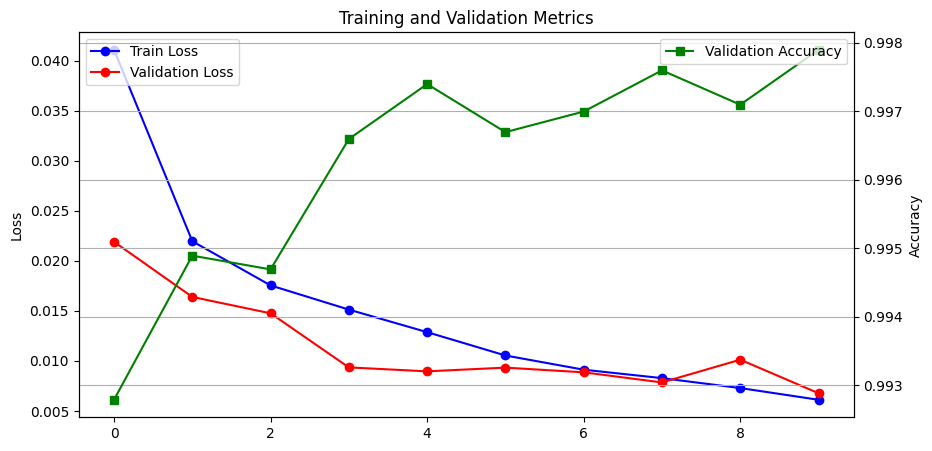

In [ ]:
log_path = "lightning_logs/version_1/metrics.csv"
df = pd.read_csv(log_path)


train_loss_df = df[["epoch", "train_loss_epoch"]].dropna()
val_loss_df = df[["epoch", "val_loss"]].dropna()
val_acc_df = df[["epoch", "val_acc"]].dropna()

plt.figure(figsize=(10, 5))

# train_loss_epoch
plt.plot(
    train_loss_df["epoch"],
    train_loss_df["train_loss_epoch"],
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="blue",
)

# val_loss
plt.plot(
    val_loss_df["epoch"],
    val_loss_df["val_loss"],
    label="Validation Loss",
    marker="o",
    linestyle="-",
    color="red",
)

# val_acc
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(
    val_acc_df["epoch"],
    val_acc_df["val_acc"],
    label="Validation Accuracy",
    marker="s",
    linestyle="-",
    color="green",
)

plt.xlabel("Epoch")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
plt.title("Training and Validation Metrics")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid()
plt.show()

Попробуем поэкспериментировать с количеством фильтров

In [ ]:
n_mels_list = [20, 40, 60]

results = {}

for n_mels in n_mels_list:
    print(f"\n=== Training with n_mels={n_mels} ===")

    train_loader = get_dataloader("training", n_mels=n_mels)
    val_loader = get_dataloader("validation", n_mels=n_mels)
    test_loader = get_dataloader("testing", n_mels=n_mels)

    model = CNN(n_mels=n_mels)

    trainer = L.Trainer(max_epochs=10)

    csv_logger = CSVLogger("logs", name=f"mel_{n_mels}")
    trainer.loggers = [csv_logger]

    trainer.fit(model, train_loader, val_loader)

    test_result = trainer.test(model, test_loader)
    test_acc = test_result[0]["test_acc"]

    history = pd.read_csv(f"{csv_logger.log_dir}/metrics.csv")
    params, flops = model_stats(model, input_shape=(1, n_mels, 101))

    results[n_mels] = {
        "model": model,
        "test_acc": test_acc,
        "history": history,
        "params": params,
        "flops": flops,
    }


=== Training with n_mels=20 ===


100%|██████████| 2.26G/2.26G [03:32<00:00, 11.4MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 2652/2652 [01:04<00:00, 40.85it/s, v_num=3, val_loss=0.00743, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2652/2652 [01:04<00:00, 40.83it/s, v_num=3, val_loss=0.00743, val_acc=0.998]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 344/344 [00:35<00:00,  9.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.997183084487915
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

=== Training with n_mels=40 ===


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 12.9 K | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 41.1 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 24.6 K | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
489 K     Trainable params
0         Non-trainable params
489 K 

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 49.99it/s]

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 2652/2652 [00:53<00:00, 49.34it/s, v_num=3, val_loss=0.00828, val_acc=0.997]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2652/2652 [00:53<00:00, 49.31it/s, v_num=3, val_loss=0.00828, val_acc=0.997]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 65.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9972739815711975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

=== Training with n_mels=60 ===


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 19.3 K | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 41.1 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 24.6 K | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
495 K     Trainable params
0         Non-trainable params
495 K 

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 2652/2652 [00:57<00:00, 45.89it/s, v_num=3, val_loss=0.00924, val_acc=0.998]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2652/2652 [00:57<00:00, 45.86it/s, v_num=3, val_loss=0.00924, val_acc=0.998]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 61.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9966378808021545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


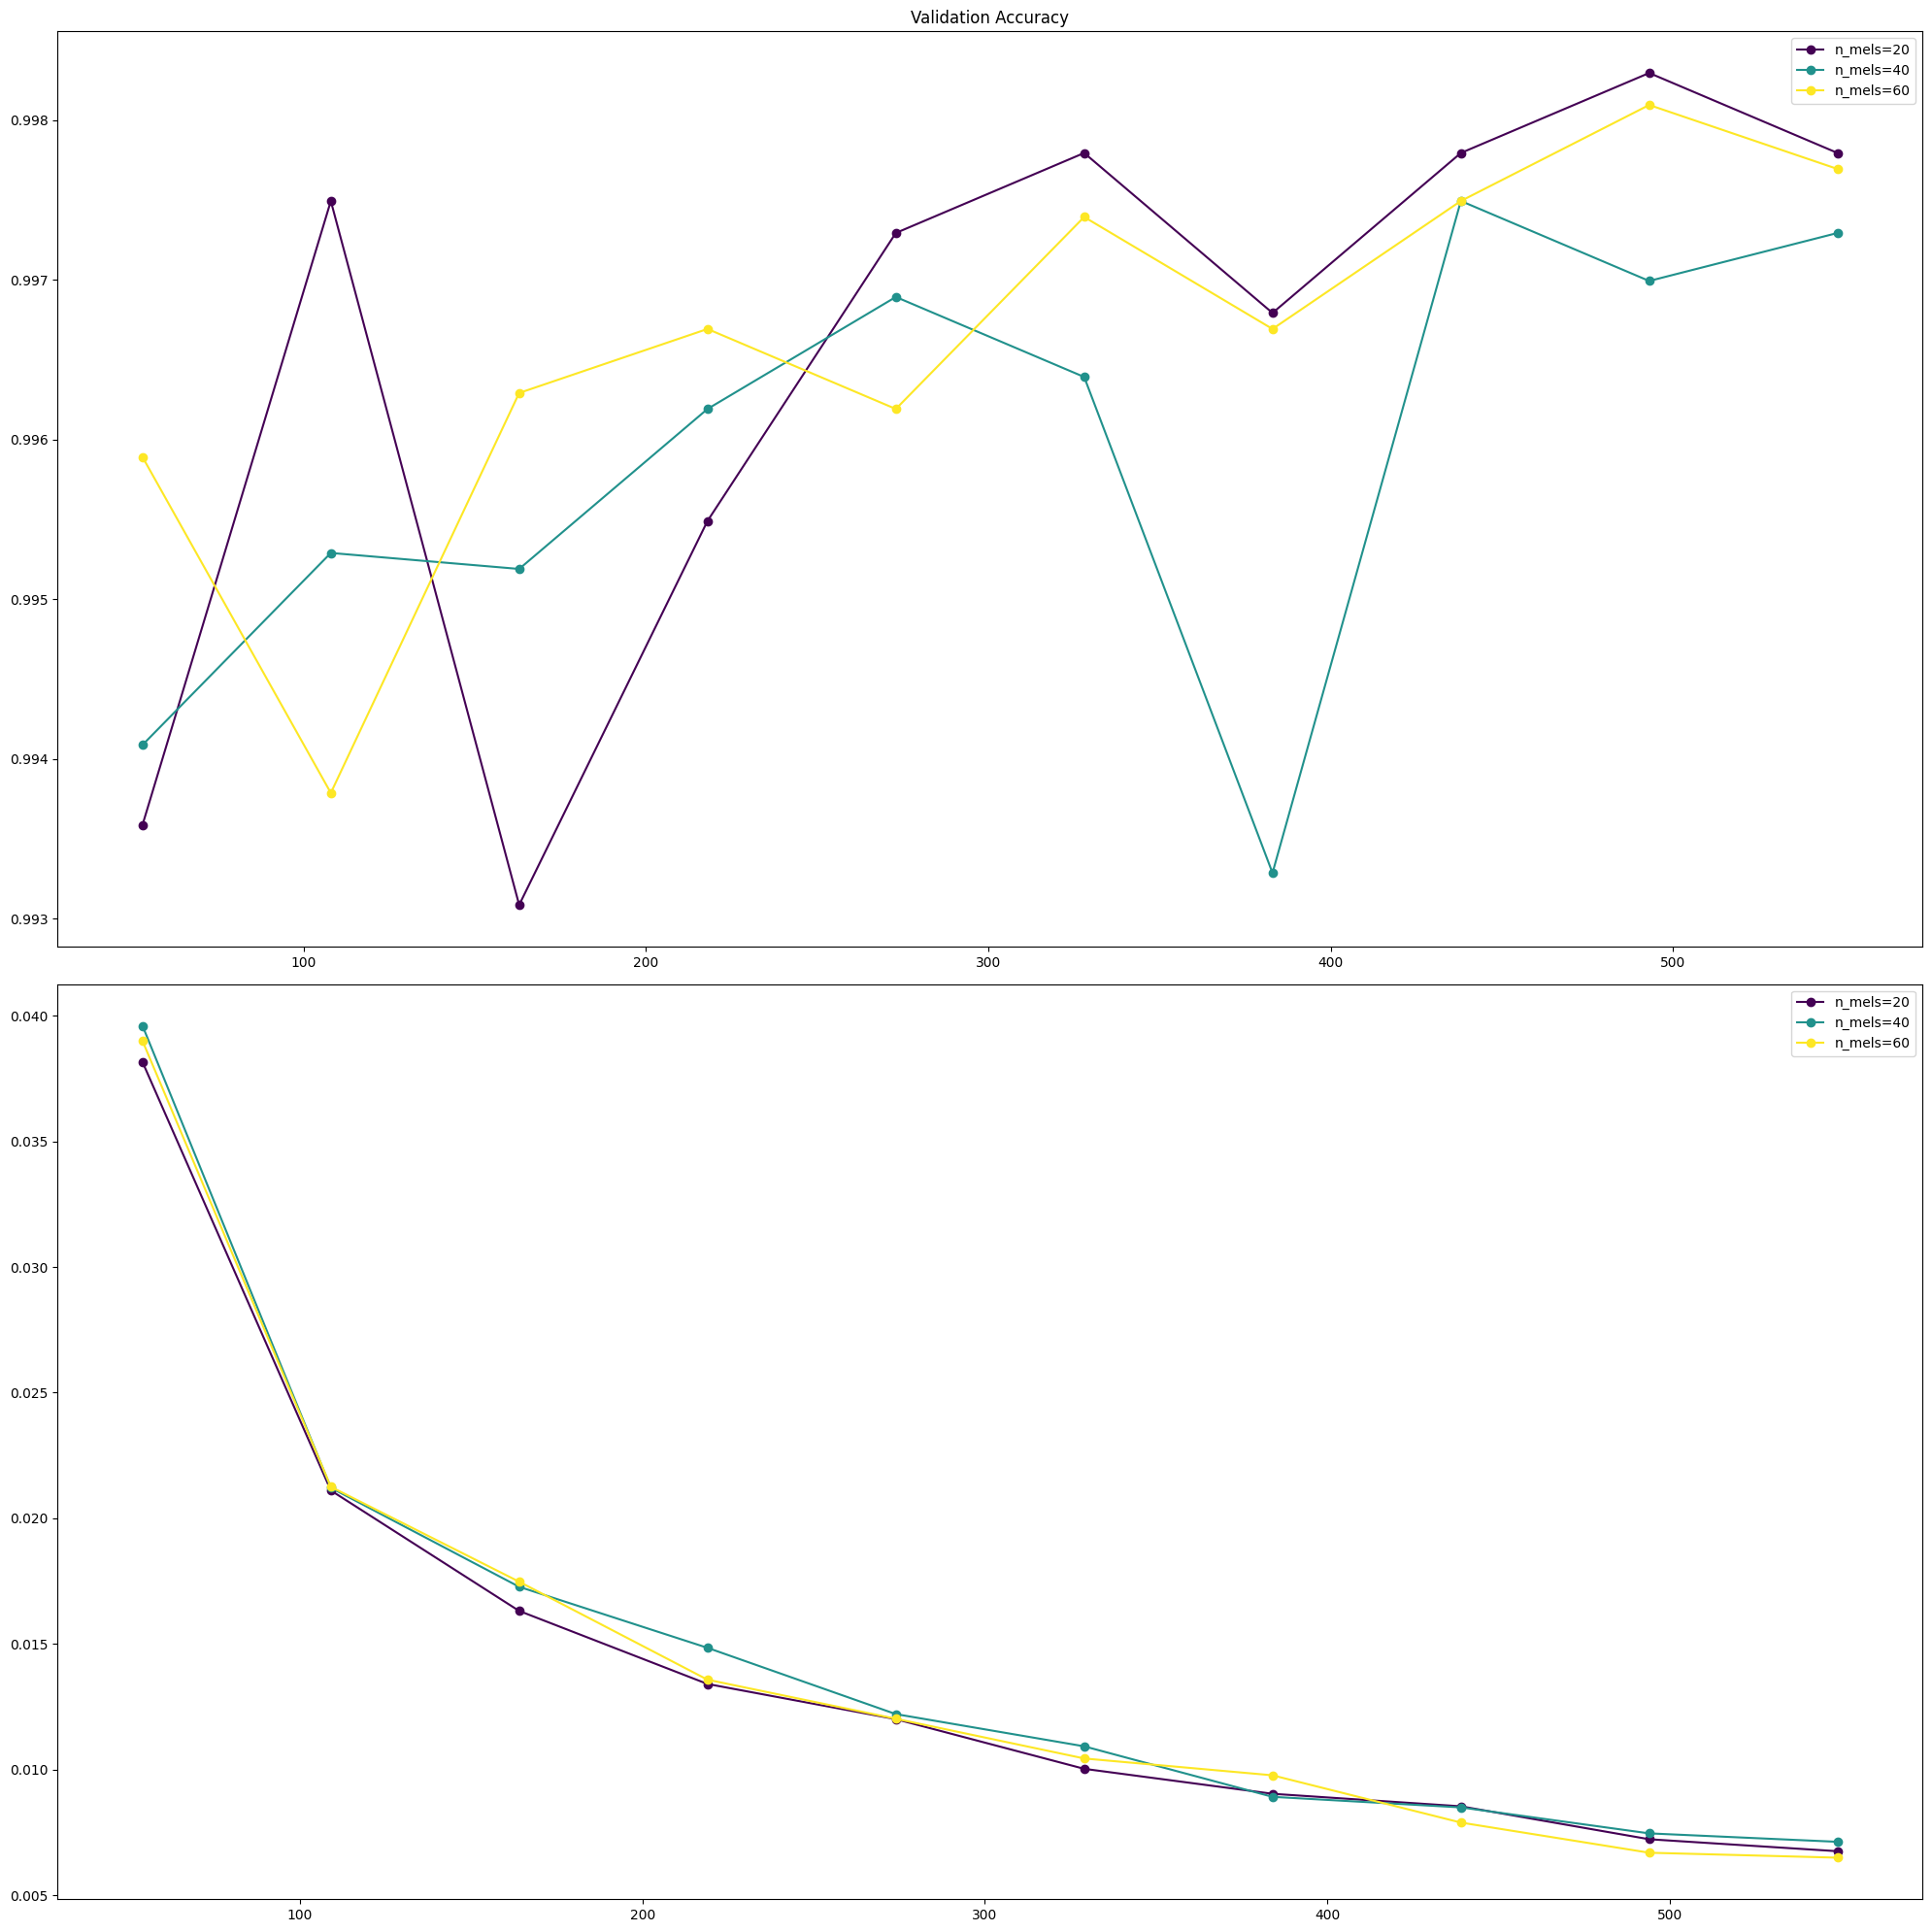

In [ ]:
plt.figure(figsize=(20, 20))

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

# val_acc
plt.subplot(2, 1, 1)
for (n_mels, res), color in zip(results.items(), colors):
    val_acc = res["history"]["val_acc"].dropna()
    plt.plot(
        val_acc.index,
        val_acc,
        label=f"n_mels={n_mels}",
        marker="o",
        linestyle="-",
        color=color,
    )
plt.title("Validation Accuracy")
plt.legend()

# train_loss_epoch
plt.subplot(2, 1, 2)
for (n_mels, res), color in zip(results.items(), colors):
    train_loss = res["history"]["train_loss_epoch"].dropna()
    plt.plot(
        train_loss.index,
        train_loss,
        label=f"n_mels={n_mels}",
        marker="o",
        linestyle="-",
        color=color,
    )
plt.legend()

plt.tight_layout()
plt.show()

Для дальнейших экспериментов выбираем значение по умолчанию, т.к. разница не то чтобы заметна. Предположительно данные слишком простые или модель чересчур сложная и можно было бы обойтись меньшими ресурсами.

Теперь поэкспериментируем с группами. Для начала скорректируем модель.

In [39]:
class CNNwthGroup(L.LightningModule):
    def __init__(self, n_mels=80, groups=1):
        super().__init__()
        self.conv1 = nn.Conv1d(
            n_mels, 64, kernel_size=5, stride=1, padding=2, groups=groups
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(
            64, 128, kernel_size=5, stride=1, padding=2, groups=groups
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(
            128, 64, kernel_size=3, stride=1, padding=1, groups=groups
        )
        self.bn3 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(64 * 25, 256)
        self.fc2 = nn.Linear(256, 2)

        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.squeeze(1)
        preds = self(x)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [41]:
groups_list = [1, 2, 4, 8]

n_mels = 80
results = {}

train_loader = get_dataloader("training")
val_loader = get_dataloader("validation")
test_loader = get_dataloader("testing")

for groups in groups_list:
    print(f"\n=== Training with groups={groups} ===")

    model = CNNwthGroup(n_mels=n_mels, groups=groups)

    # Колбек для измерения времени эпохи
    epoch_times = []

    class TimingCallback(L.Callback):
        def on_train_epoch_start(self, trainer, l_module):
            self.epoch_start = time.time()

        def on_train_epoch_end(self, trainer, l_module):
            epoch_time = time.time() - self.epoch_start
            epoch_times.append(epoch_time)
            l_module.log("epoch_time", epoch_time)

    trainer = L.Trainer(
        max_epochs=3,
        callbacks=[TimingCallback()],
        logger=CSVLogger("logs", name=f"groups_{groups}"),
        enable_progress_bar=True,
    )

    params, flops = model_stats(model, input_shape=(1, n_mels, 101))

    trainer.fit(model, train_loader, val_loader)

    test_result = trainer.test(model, test_loader)

    history = pd.read_csv(f"{csv_logger.log_dir}/metrics.csv")
    avg_epoch_time = np.mean(epoch_times)

    results[groups] = {
        "params": params,
        "flops": flops,
        "test_acc": test_result[0]["test_acc"],
        "avg_epoch_time": avg_epoch_time,
        "history": history,
    }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 25.7 K | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 41.1 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 24.6 K | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
502 K     Trainable params
0         Non-trainable params
502 K 


=== Training with groups=1 ===
Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.62it/s, v_num=3, val_loss=0.0113, val_acc=0.997]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.60it/s, v_num=3, val_loss=0.0113, val_acc=0.997]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 62.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9959109425544739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

=== Training with groups=2 ===


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 12.9 K | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 20.6 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 12.4 K | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
456 K     Trainable params
0         Non-trainable params
456 K 

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.78it/s, v_num=0, val_loss=0.0126, val_acc=0.996]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.76it/s, v_num=0, val_loss=0.0126, val_acc=0.996]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 63.41it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9962744116783142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

=== Training with groups=4 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 6.5 K  | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 10.4 K | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 6.2 K  | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
433 K     Trainable params
0         Non-trainable params
433 K     Total params
1.736     Total estimated model params size (MB)
12        Modules in train mode
0         Modules 

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.58it/s, v_num=0, val_loss=0.0134, val_acc=0.996]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2652/2652 [00:55<00:00, 47.56it/s, v_num=0, val_loss=0.0134, val_acc=0.996]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 63.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9953657388687134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

=== Training with groups=8 ===


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params | Mode 
--------------------------------------------------------
0  | conv1     | Conv1d           | 3.3 K  | train
1  | bn1       | BatchNorm1d      | 128    | train
2  | pool1     | MaxPool1d        | 0      | train
3  | conv2     | Conv1d           | 5.2 K  | train
4  | bn2       | BatchNorm1d      | 256    | train
5  | pool2     | MaxPool1d        | 0      | train
6  | conv3     | Conv1d           | 3.1 K  | train
7  | bn3       | BatchNorm1d      | 128    | train
8  | fc1       | Linear           | 409 K  | train
9  | fc2       | Linear           | 514    | train
10 | criterion | CrossEntropyLoss | 0      | train
11 | dropout   | Dropout          | 0      | train
--------------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K 

d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 2652/2652 [00:56<00:00, 47.26it/s, v_num=0, val_loss=0.0126, val_acc=0.996]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2652/2652 [00:56<00:00, 47.24it/s, v_num=0, val_loss=0.0126, val_acc=0.996]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


d:\code\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 344/344 [00:05<00:00, 64.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.995002269744873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Построим графики экспериментов

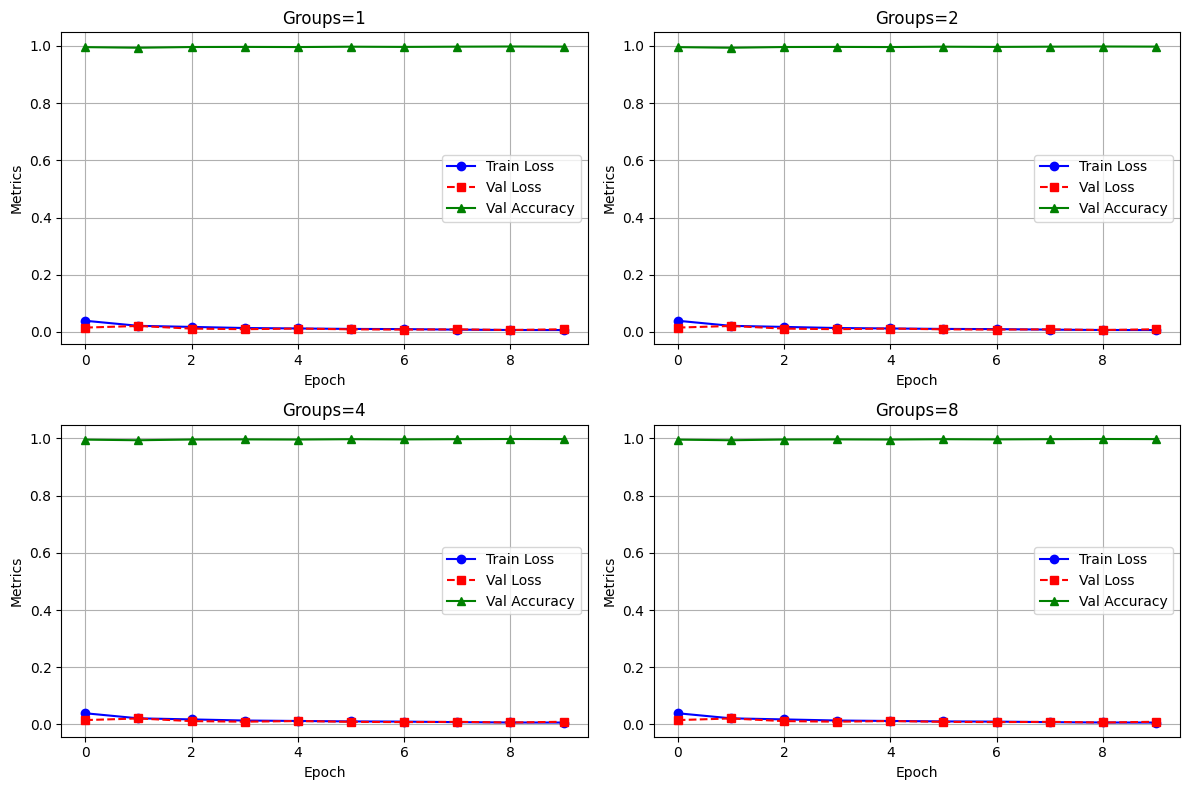

In [45]:
plt.figure(figsize=(12, 8))

colors = ["blue", "red", "green", "purple"]

for i, (groups, data) in enumerate(results.items()):
    history = data["history"]

    # Фильтруем NaN
    train_loss_df = history[["epoch", "train_loss_epoch"]].dropna()
    val_loss_df = history[["epoch", "val_loss"]].dropna()
    val_acc_df = history[["epoch", "val_acc"]].dropna()

    plt.subplot(2, 2, i + 1)

    # Потери
    plt.plot(
        train_loss_df["epoch"],
        train_loss_df["train_loss_epoch"],
        label="Train Loss",
        linestyle="-",
        marker="o",
        color=colors[0],
    )
    plt.plot(
        val_loss_df["epoch"],
        val_loss_df["val_loss"],
        label="Val Loss",
        linestyle="--",
        marker="s",
        color=colors[1],
    )

    # Точность
    plt.plot(
        val_acc_df["epoch"],
        val_acc_df["val_acc"],
        label="Val Accuracy",
        linestyle="-",
        marker="^",
        color=colors[2],
    )

    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    plt.title(f"Groups={groups}")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

Как видно, количество групп не повляло на метрики качества

Теперь посмотрим на данные по сокрости и вычислениям в зависимости от количества групп

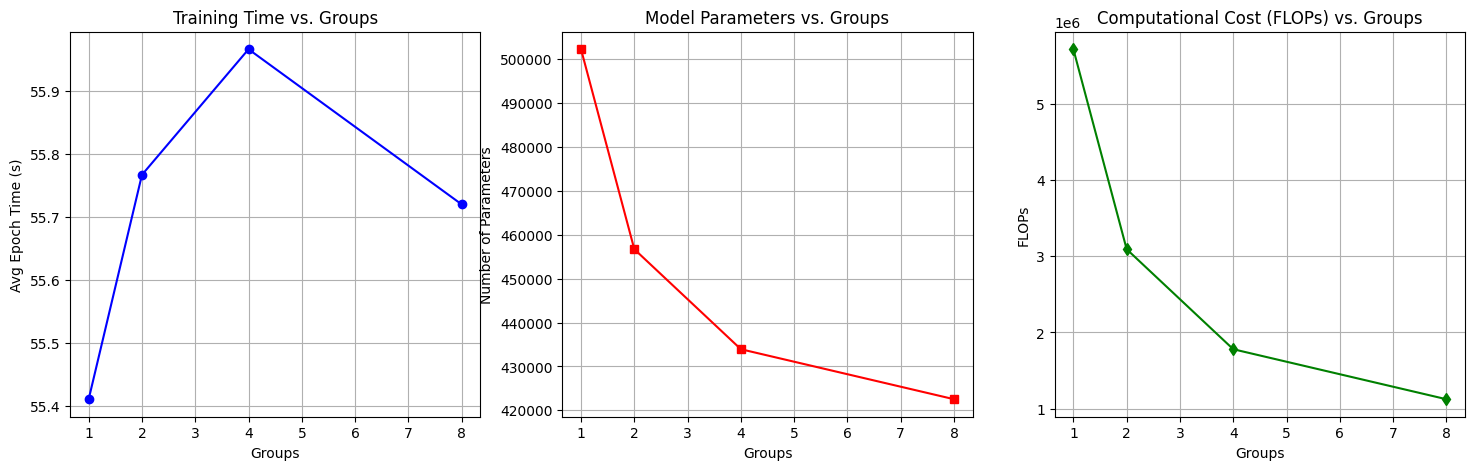

In [44]:
groups_list = list(results.keys())
avg_epoch_times = [results[g]["avg_epoch_time"] for g in groups_list]
params_list = [results[g]["params"] for g in groups_list]
flops_list = [results[g]["flops"] for g in groups_list]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Время обучения / количество групп
axes[0].plot(groups_list, avg_epoch_times, marker="o", linestyle="-", color="blue")
axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Avg Epoch Time (s)")
axes[0].set_title("Training Time vs. Groups")
axes[0].grid()

# Количество параметров / количество групп
axes[1].plot(groups_list, params_list, marker="s", linestyle="-", color="red")
axes[1].set_xlabel("Groups")
axes[1].set_ylabel("Number of Parameters")
axes[1].set_title("Model Parameters vs. Groups")
axes[1].grid()

# FLOPs / количество групп
axes[2].plot(groups_list, flops_list, marker="d", linestyle="-", color="green")
axes[2].set_xlabel("Groups")
axes[2].set_ylabel("FLOPs")
axes[2].set_title("Computational Cost (FLOPs) vs. Groups")
axes[2].grid()

plt.show()

Время тренировки как будто не сильно зависит от количества групп. Разница в значениях больше похожа на погрешность

С количеством параметров интереснее. При увекличении групп уменьшилось количество обучаемых параметров сверток, что и видно на графике. 

Зато стоимость вычислений упала в 6 раз с увеличением количества групп. Если бы более эффективно загрузить видеокарту, то наверняка можно было бы и время сэкономить